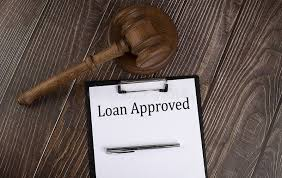

# **IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC

# **read data**

In [ ]:
df=pd.read_csv('/content/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

# **Clean data**

In [ ]:
cols_to_convert = ['loan_amnt', 'person_age','person_income','cb_person_cred_hist_length']
for col in cols_to_convert:
   df[col] = df[col].astype('Int64')

In [ ]:
print(f"num of missing values = {df.isna().sum().sum()}")
df.isna().sum()

num of missing values = 0


,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


# **It's great that there are no missing values! 😎**

In [ ]:
print(f"num of dublicate rows = {df.duplicated().sum().sum()}")

num of dublicate rows = 0


# **EDA / Univariate Analysis**

In [ ]:
num_col=df.select_dtypes(include='number').columns
cat_col=df.select_dtypes(exclude='number').columns

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.0,24.0,26.0,30.0,144.0
person_income,45000.0,80319.053222,80422.498632,8000.0,47204.0,67048.0,95789.25,7200766.0
person_emp_exp,45000.0,5.410333,6.063532,0.0,1.0,4.0,8.0,125.0
loan_amnt,45000.0,9583.157556,6314.886691,500.0,5000.0,8000.0,12237.25,35000.0
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.0
loan_percent_income,45000.0,0.139725,0.087212,0.0,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.0,3.0,4.0,8.0,30.0
credit_score,45000.0,632.608756,50.435865,390.0,601.0,640.0,670.0,850.0
loan_status,45000.0,0.222222,0.415744,0.0,0.0,0.0,0.0,1.0


# **It seems some columns have illogical values, like age and income—let's verify! 🤔**

In [ ]:
sns.set_style('darkgrid')
def visula_numcol(df,num_col):
 for col in num_col:
  if col!='loan_status':
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

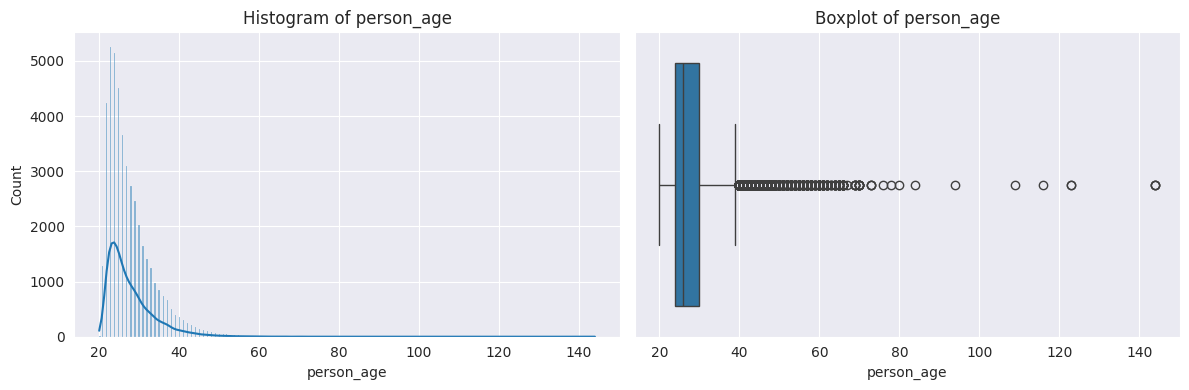

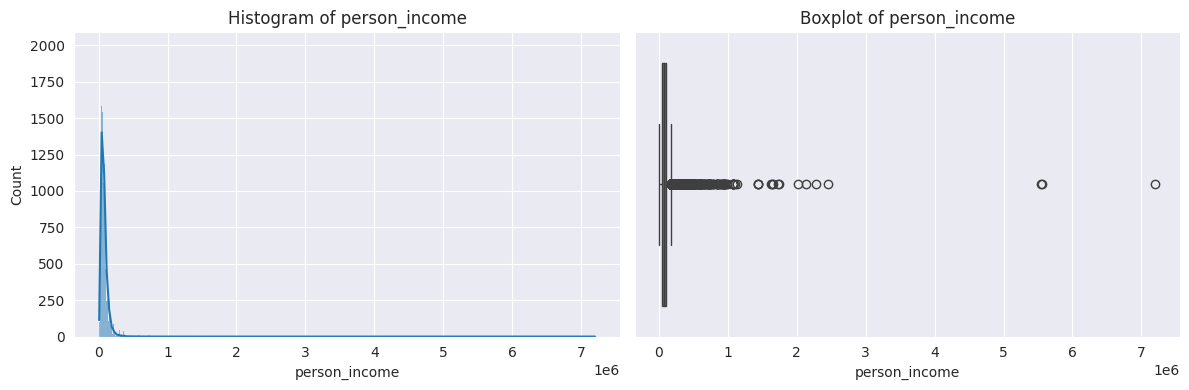

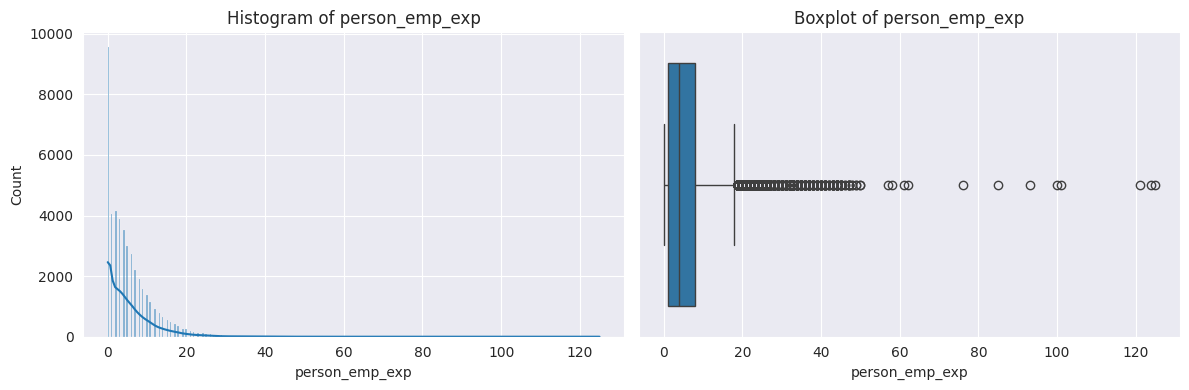

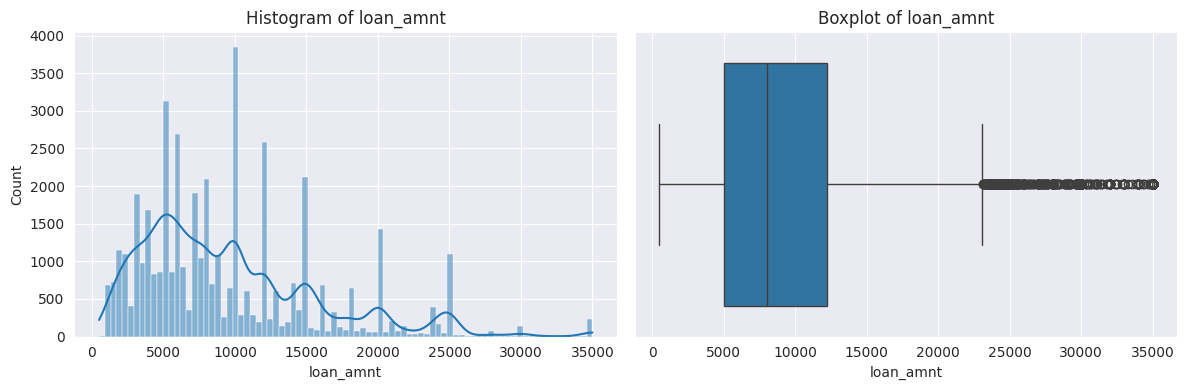

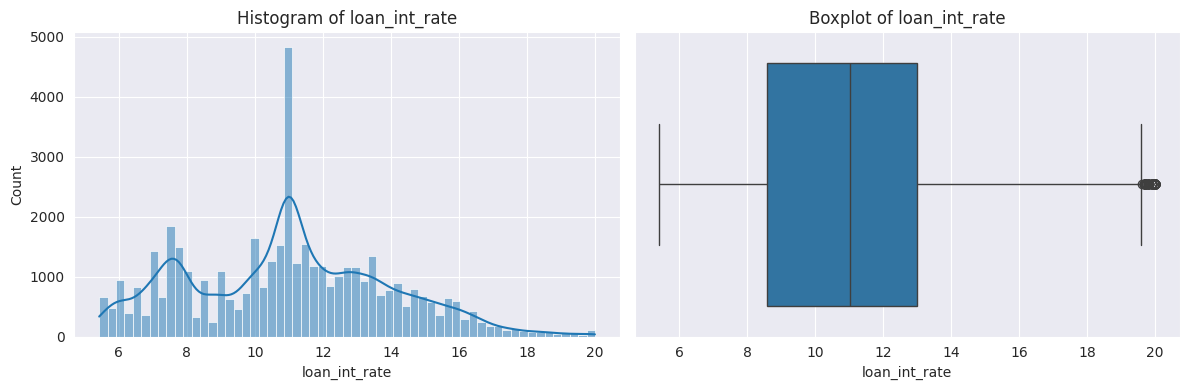

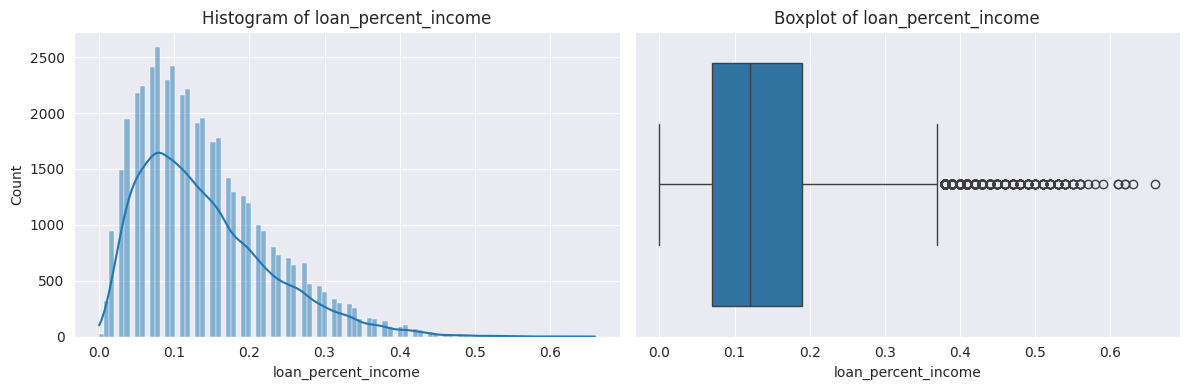

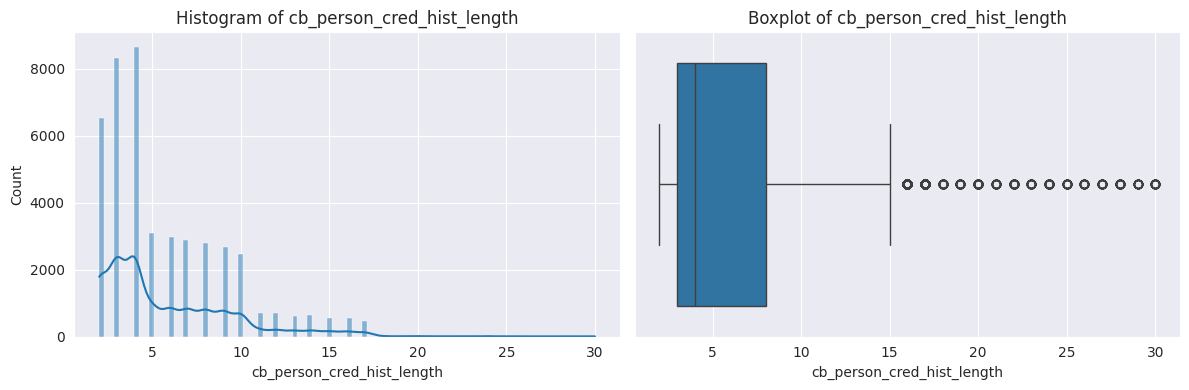

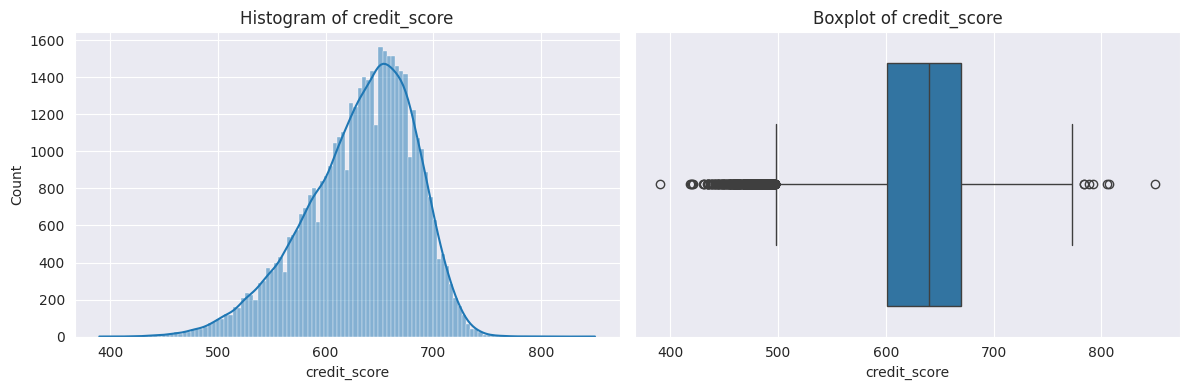

In [ ]:
visula_numcol(df,num_col)

# **Indeed, it looks like there’s a significant amount of outlier values! 😮**

In [ ]:
def handle_outlier(df, num_cols, strategy='replace'):
 outlier_report = []
 for col in num_cols:
   if col!='loan_status':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        n_outliers = outliers.shape[0]

        outlier_report.append({
            'column': col,
            'outliers_found': n_outliers,
            'lower_bound': lower,
            'upper_bound': upper
        })

        if strategy == 'replace':
            median = df[col].median()
            df[col] = np.where((df[col] < lower) | (df[col] > upper), median, df[col])

        elif strategy == 'remove':
            df = df[~((df[col] < lower) | (df[col] > upper))]

 report_df = pd.DataFrame(outlier_report)
 return  report_df

In [ ]:
handle_outlier(df,num_col,strategy='replace')

,column,outliers_found,lower_bound,upper_bound
0,person_age,2188,15.000,39.000
1,person_income,2218,-25673.875,168667.125
2,person_emp_exp,1724,-9.500,18.500
3,loan_amnt,2348,-5855.875,23093.125
4,loan_int_rate,124,1.990,19.590
5,loan_percent_income,744,-0.110,0.370
6,cb_person_cred_hist_length,1366,-4.500,15.500
7,credit_score,467,497.500,773.500


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,26.812644,4.185092,20.00,24.00,26.00,29.00,39.00
person_income,45000.0,70668.706667,31651.673019,8000.00,47204.00,67048.00,88573.00,168653.00
person_emp_exp,45000.0,4.614800,4.396140,0.00,1.00,4.00,7.00,18.00
loan_amnt,45000.0,8623.517178,4872.281839,500.00,5000.00,8000.00,12000.00,23050.00
loan_int_rate,45000.0,10.982034,2.941660,5.42,8.59,11.01,12.99,19.59
loan_percent_income,45000.0,0.134709,0.078880,0.00,0.07,0.12,0.18,0.37
cb_person_cred_hist_length,45000.0,5.434622,3.149065,2.00,3.00,4.00,7.00,15.00
credit_score,45000.0,634.244200,47.837372,498.00,603.00,640.00,670.00,773.00
loan_status,45000.0,0.222222,0.415744,0.00,0.00,0.00,0.00,1.00


# **Most data has become normalized, but there are still large gaps in person_income and loan_amnt—these will be handled in the scaler stage! ✅**

**Now, let’s take a look at the categorical features ! 👀**

In [ ]:
def analyze_categorical(df, cat_col):
    for col in cat_col:
        val_counts = df[col].value_counts()
        val_perc = df[col].value_counts(normalize=True).round(3) * 100
        unique = df[col].nunique()


        fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})


        sns.countplot(data=df, x=col, ax=axs[0], order=val_counts.index, palette='Set2')
        axs[0].set_title(f'{col} - Count')
        axs[0].set_xlabel('')
        axs[0].set_ylabel('Count')
        axs[0].tick_params(axis='x', rotation=45)

        axs[1].axis('off')
        text = f'Unique Values: {unique}\n\n'
        for cat, count, perc in zip(val_counts.index, val_counts, val_perc):
            text += f'{cat}: {count} ({perc:.1f}%)\n'
        axs[1].text(0, 1, text, ha='left', va='top', fontsize=11, family='monospace')

        plt.tight_layout()
        plt.show()

In [ ]:
print(cat_col)

Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object')


***Great, I’ll split them for easier reading! 📝***

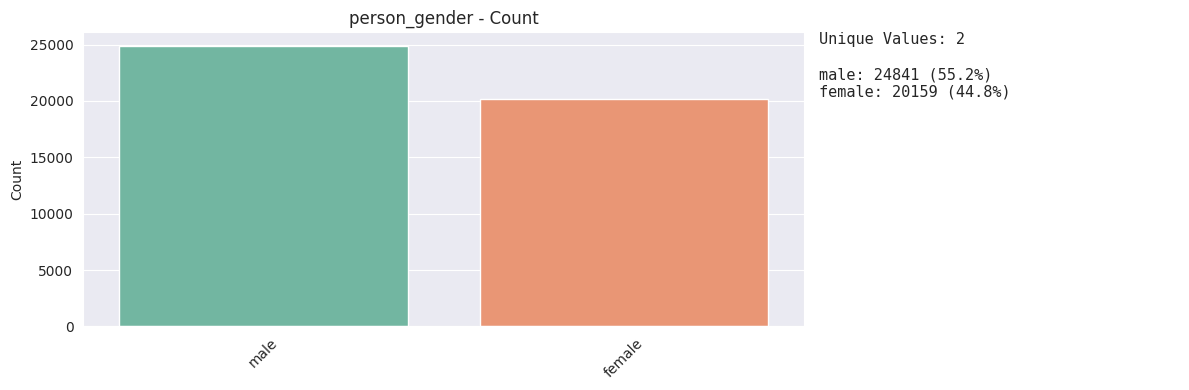

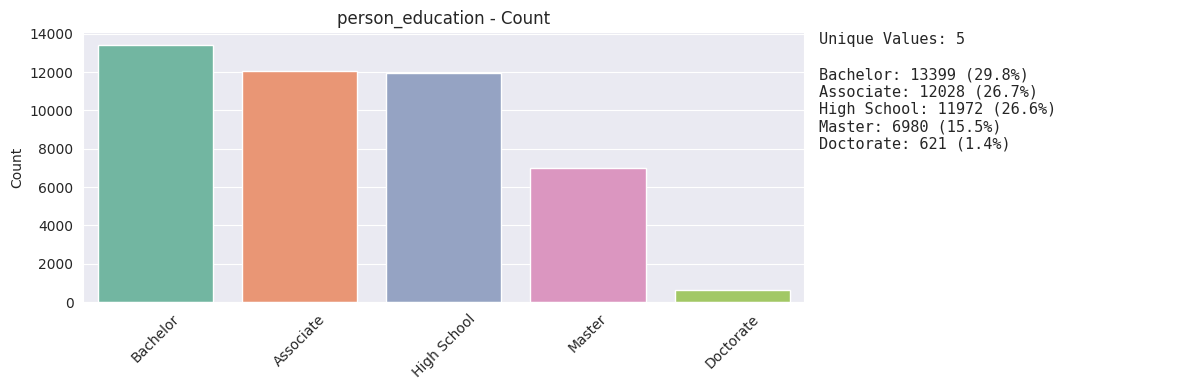

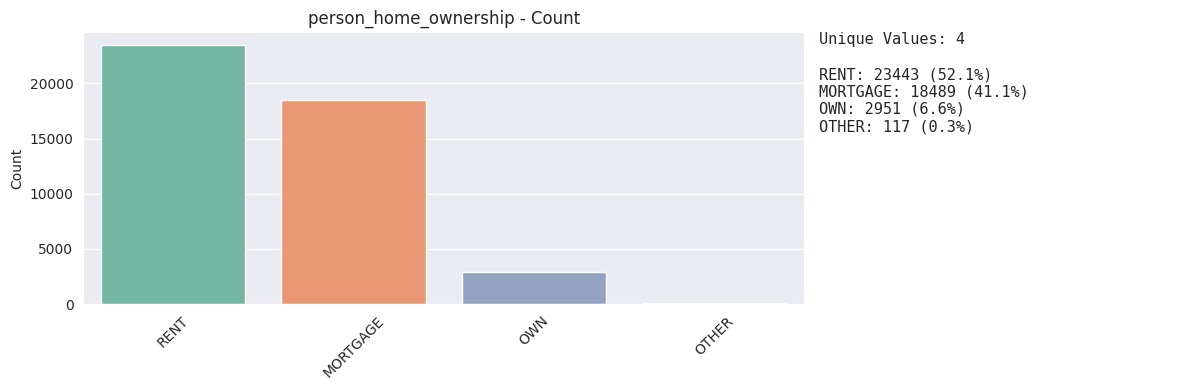

In [ ]:
analyze_categorical(df,['person_gender','person_education','person_home_ownership'])

# The conclusions from the first part are that most loan applicants are recent graduates and students, unlike those with PhDs or master's degrees, and also include renters and individuals with mortgaged properties. 📊

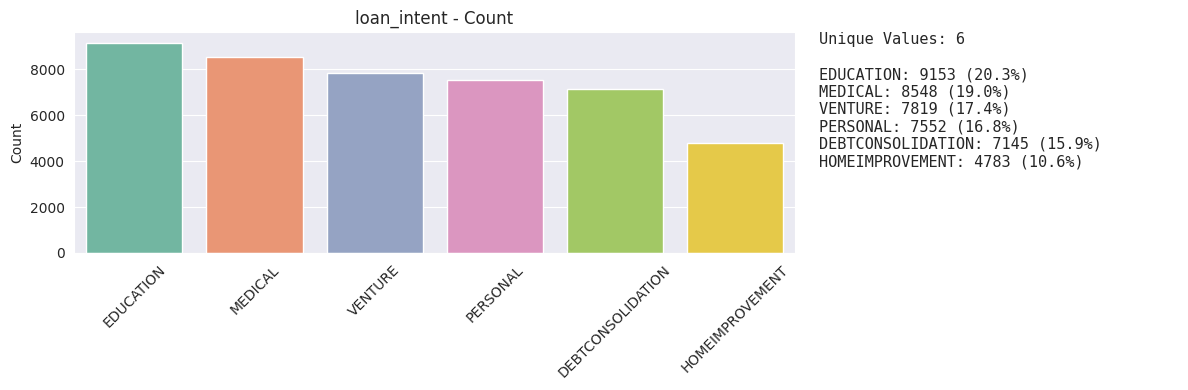

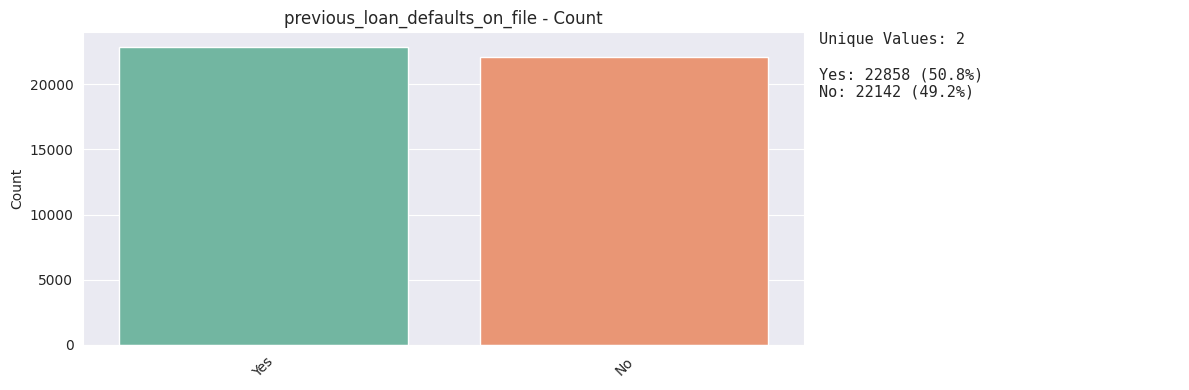

In [ ]:
analyze_categorical(df,['loan_intent','previous_loan_defaults_on_file'])

# **It seems there is a convergence among loan request categories, with a slight lead for education. 🎓**

In [ ]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0.0,RENT,8000.0,PERSONAL,16.02,0.12,3.0,561.0,No,1
1,21.0,female,High School,12282.0,0.0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504.0,Yes,0
2,25.0,female,High School,12438.0,3.0,MORTGAGE,5500.0,MEDICAL,12.87,0.12,3.0,635.0,No,1
3,23.0,female,Bachelor,79753.0,0.0,RENT,8000.0,MEDICAL,15.23,0.12,2.0,675.0,No,1
4,24.0,male,Master,66135.0,1.0,RENT,8000.0,MEDICAL,14.27,0.12,4.0,586.0,No,1


# **multi varient analysis**

**Now I will conduct a multivariate analysis with a target column 😄**

In [ ]:
def hue_categorical_analysis(df, cat_col, target_col):
   for col in cat_col:
        plt.figure(figsize=(12, 4))
        sns.countplot(data=df, x=col, hue=target_col, palette='Pastel1', order=df[col].value_counts().index)
        plt.title(f'{col} by {target_col}')
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)

        plt.legend(title=target_col, loc='upper right', bbox_to_anchor=(1, 1.15))

        plt.tight_layout()
        plt.show()

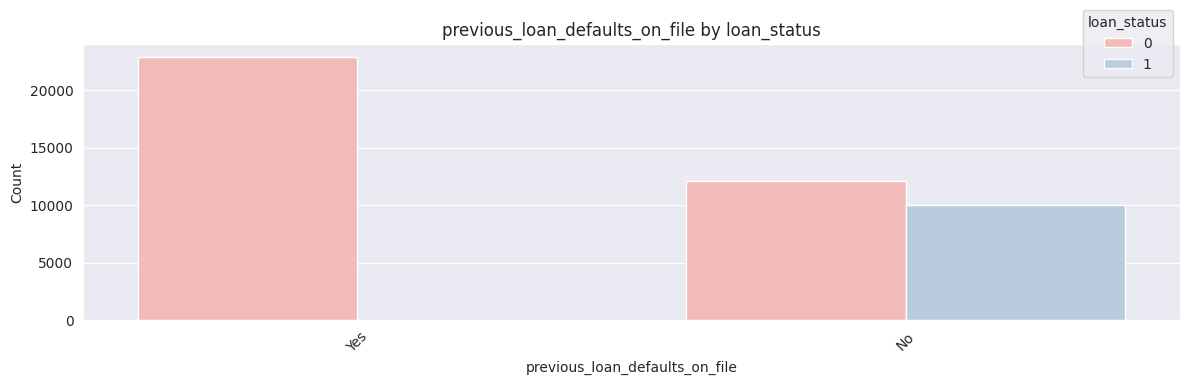

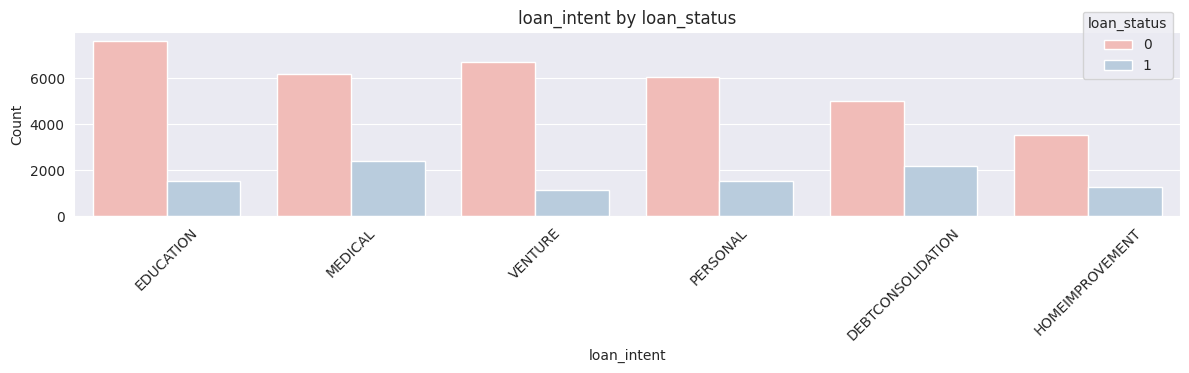

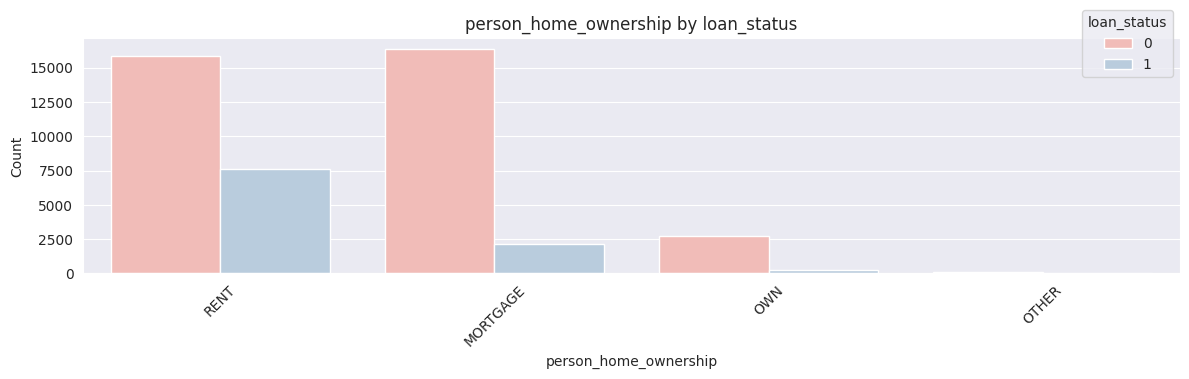

In [ ]:
import_cat_col=['previous_loan_defaults_on_file','loan_intent','person_home_ownership']
hue_categorical_analysis(df,import_cat_col,'loan_status')

# **The important indicator derived is that anyone who defaults on any loan repayments will not have their request approved 🚨**

In [ ]:
def hue_numeric_analysis(df, num_cols, target_col):
    for col in num_cols:
        plt.figure(figsize=(12, 4))
        sns.kdeplot(
            data=df, x=col, hue=target_col,
            fill=True, common_norm=False, palette='Pastel1', alpha=0.6
        )
        plt.title(f'Distribution of {col} by {target_col}')
        plt.xlabel(col)
        plt.ylabel('Density')

        plt.legend(title=target_col, loc='upper right', bbox_to_anchor=(1, 1.15))

        plt.tight_layout()
        plt.show()

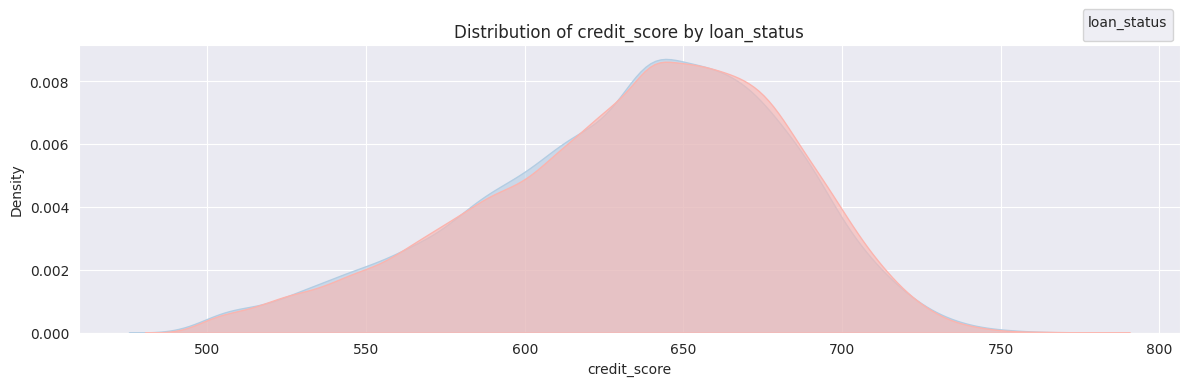

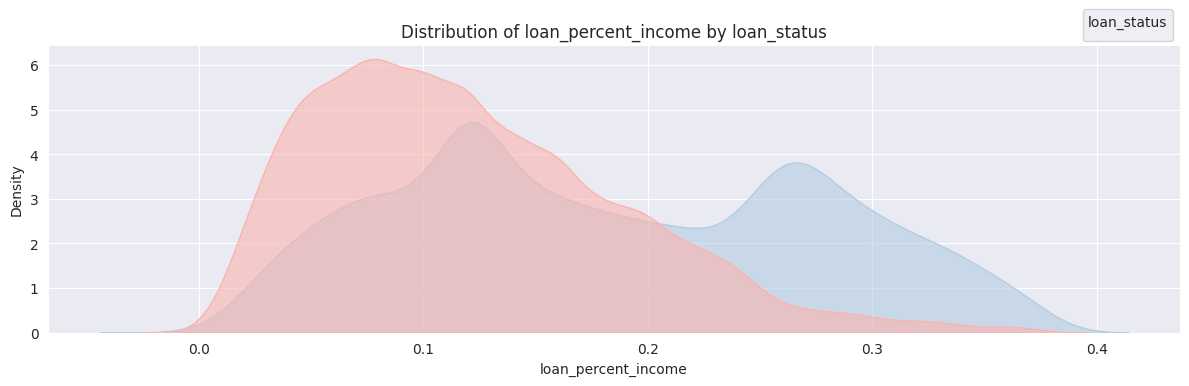

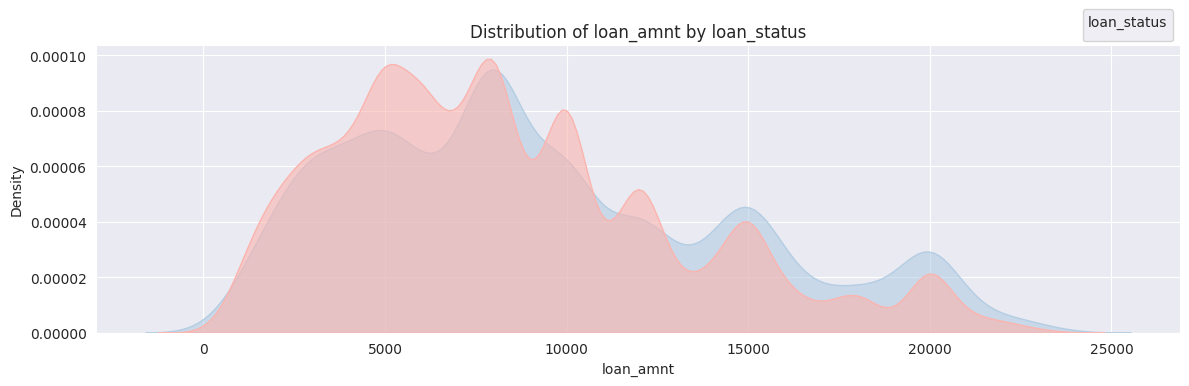

In [ ]:
import_num_cols = ['credit_score', 'loan_percent_income', 'loan_amnt']
hue_numeric_analysis(df,import_num_cols,'loan_status')

# **Transformation For The  Data**

In [ ]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0.0,RENT,8000.0,PERSONAL,16.02,0.12,3.0,561.0,No,1
1,21.0,female,High School,12282.0,0.0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504.0,Yes,0
2,25.0,female,High School,12438.0,3.0,MORTGAGE,5500.0,MEDICAL,12.87,0.12,3.0,635.0,No,1
3,23.0,female,Bachelor,79753.0,0.0,RENT,8000.0,MEDICAL,15.23,0.12,2.0,675.0,No,1
4,24.0,male,Master,66135.0,1.0,RENT,8000.0,MEDICAL,14.27,0.12,4.0,586.0,No,1


In [ ]:
edu_order = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']]
encoder = OrdinalEncoder(categories=edu_order)

df[['person_education']] = encoder.fit_transform(df[['person_education']])

In [ ]:
le = LabelEncoder()
df['person_gender'] = le.fit_transform(df['person_gender'])
df['previous_loan_defaults_on_file'] = le.fit_transform(df['previous_loan_defaults_on_file'])

In [ ]:
display(df.head())

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,3.0,71948.0,0.0,RENT,8000.0,PERSONAL,16.02,0.12,3.0,561.0,0,1
1,21.0,0,0.0,12282.0,0.0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504.0,1,0
2,25.0,0,0.0,12438.0,3.0,MORTGAGE,5500.0,MEDICAL,12.87,0.12,3.0,635.0,0,1
3,23.0,0,2.0,79753.0,0.0,RENT,8000.0,MEDICAL,15.23,0.12,2.0,675.0,0,1
4,24.0,1,3.0,66135.0,1.0,RENT,8000.0,MEDICAL,14.27,0.12,4.0,586.0,0,1


In [ ]:
X=df.drop('loan_status',axis=1)
y=df['loan_status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
scaler=RobustScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)
    ],
    remainder='passthrough'
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# **feature_selection**

In [ ]:
from sklearn.feature_selection import RFE
# جاهز تستخدمهم
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(kernel='linear')
}

results = []

for name, model in models.items():
    print(f'\nRunning RFE with {name}...')
    rfe = RFE(estimator=model, n_features_to_select=10)
    X_train_rfe = rfe.fit_transform(X_train_transformed, y_train)
    X_test_rfe = rfe.transform(X_test_transformed)


    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    acc = accuracy_score(y_test, y_pred)

    results.append((name, acc))
    print(f'Accuracy: {acc:.4f}')


Running RFE with LogisticRegression...
Accuracy: 0.8761

Running RFE with RandomForest...
Accuracy: 0.9158

Running RFE with SVM...
Accuracy: 0.8842


In [ ]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

xgb = XGBClassifier()
rfe_xgb = RFE(estimator=xgb, n_features_to_select=10)
X_train_rfe_xgb = rfe_xgb.fit_transform(X_train_transformed, y_train)
X_test_rfe_xgb = rfe_xgb.transform(X_test_transformed)

In [ ]:
print(X_train_rfe.shape)
print(X_train_rfe_xgb.shape)

(36000, 10)
(36000, 10)


# **Grid search**

In [ ]:

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}


In [ ]:
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

svm_grid = GridSearchCV(
    SVC(),
    svm_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [ ]:
rf_grid.fit(X_train_rfe, y_train)
svm_grid.fit(X_train_rfe, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [ ]:
print("Best RF Params:", rf_grid.best_params_)
print("Best RF Score:", rf_grid.best_score_)

print("Best SVM Params:", svm_grid.best_params_)
print("Best SVM Score:", svm_grid.best_score_)

Best RF Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RF Score: 0.9209999999999999
Best SVM Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Score: 0.9076666666666666


In [ ]:
rf_y_pred=rf_grid.predict(X_test_rfe)
rf_test_acc = accuracy_score(y_test,rf_y_pred)
svm_y_pred=svm_grid.predict(X_test_rfe)
svm_test_acc = accuracy_score(y_test, svm_y_pred)

print("Random Forest Test Accuracy:", rf_test_acc)
print("SVM Test Accuracy:", svm_test_acc)

Random Forest Test Accuracy: 0.9216666666666666
SVM Test Accuracy: 0.9092222222222223


In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1]
}


xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train_rfe_xgb, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8]},
             scoring='accuracy', verbose=1)

In [ ]:
y_pred=xgb_grid.predict(X_test_rfe_xgb)
print(f"XGB TEST SCORE ={accuracy_score(y_test,y_pred)}")
y_pred_train=xgb_grid.predict(X_train_rfe_xgb)
print(f"XGB Train SCORE ={accuracy_score(y_train,y_pred_train)}")

XGB TEST SCORE =0.9326666666666666
XGB Train SCORE =0.9535277777777778


# **XGB  is winning 🏆.**

<Axes: >

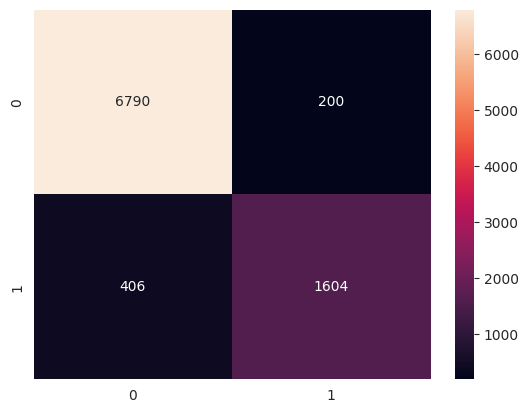

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6990
           1       0.89      0.80      0.84      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.88      0.90      9000
weighted avg       0.93      0.93      0.93      9000



In [ ]:
feature_importances = xgb_grid.best_estimator_.feature_importances_

selected_feature_names = preprocessor.get_feature_names_out()[rfe_xgb.support_]

feature_importance_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
3,num__previous_loan_defaults_on_file,0.895421
5,cat__person_home_ownership_RENT,0.025734
4,cat__person_home_ownership_OWN,0.018455
2,num__loan_percent_income,0.012905
7,cat__loan_intent_HOMEIMPROVEMENT,0.009480
1,num__loan_int_rate,0.009034
0,num__person_income,0.008389
9,cat__loan_intent_VENTURE,0.008065
8,cat__loan_intent_MEDICAL,0.006550
6,cat__loan_intent_DEBTCONSOLIDATION,0.005966


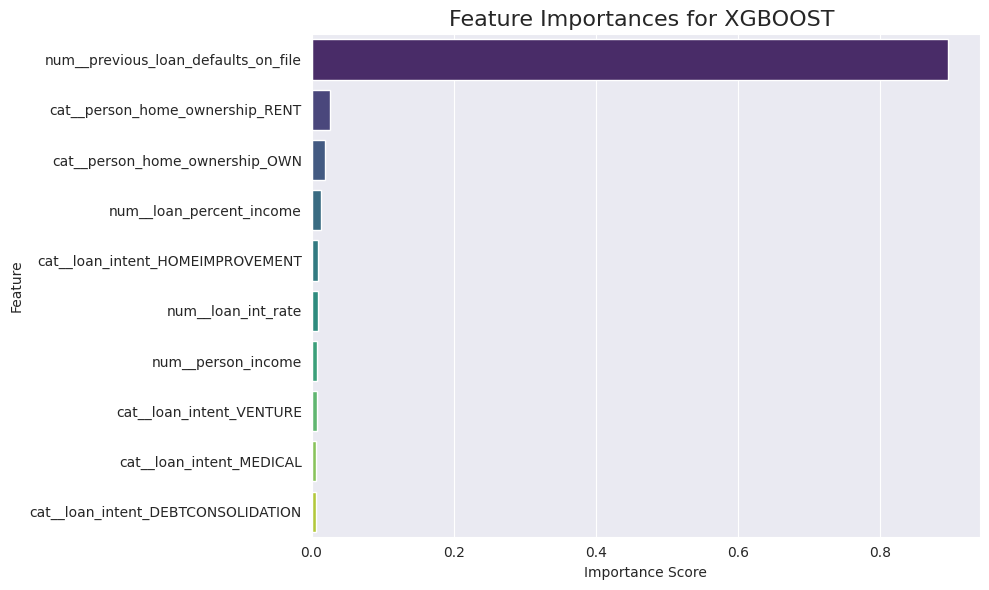

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances for XGBOOST ',fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
import joblib
joblib.dump(xgb_grid, 'Loan classification')

['Loan classification']

In [ ]:
df.select_dtypes